In [2]:
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [3]:
def fibonacci_sphere(R=1.0, samples=1):

    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = R*(1 - (i / float(samples - 1)) * 2)  # y goes from 1 to -1
        radius = math.sqrt(R*R - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append([x, y, z])

    return points

In [4]:
import sys
from io import StringIO
from IPython import get_ipython


class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


def ipy_exit():
    raise IpyExit


if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit      # just make exit importable

In [94]:
from scipy import integrate
import numpy.ma as ma
import matplotlib
from matplotlib import cm

In [47]:
L=5                        #radius of condensate
R=0.25                     #RNA length/2
#x = np.arange(20,800,50)  #aggregate size
x = np.arange(820,1000,50) 
epsilon = 0.005
D_o=30
k_in = 2
coef = k_in/4/np.pi
lamb0 = 1+coef/D_o*(-1/(2*R))
D_in=[1,3,30]  
#D_in=[1]

final=[]
final_std=[]


for D_i in D_in:
    mean=[]
    D_p = D_o + D_i
    D_m = D_o - D_i
    
    y2 = lambda t,a1,a2,a3,b1,b2,b3: t**(-D_o/D_p)/((a1-b1*t)**2+(a2-b2*t)**2+(a3-b3*t)**2)**(0.5)
    
    for sample in range(20):   #run 5 times to calculate statistic average and variance          
        ansN=[]

        for N in x:
            pos=(np.random.rand(3,N)-np.ones((3,N))/2)*2*L
            
            theta=np.random.rand(N)*np.pi
            phi=np.random.rand(N)*2*np.pi
            dx=R*np.sin(theta)*np.sin(phi)
            dy=R*np.sin(theta)*np.cos(phi)
            dz=R*np.cos(theta)

            Tpos_B=[]
            Tpos_E=[]
            Tpos_B.append(pos[0]+dx)
            Tpos_B.append(pos[1]+dy)
            Tpos_B.append(pos[2]+dz)
            Tpos_E.append(pos[0]-dx)
            Tpos_E.append(pos[1]-dy)
            Tpos_E.append(pos[2]-dz)

            pos_Ba=np.transpose(Tpos_B)
            pos_Ea=np.transpose(Tpos_E)
            pos_B=[]
            pos_E=[]
            for i in range(N):
                if (pos[0][i]**2 + pos[1][i]**2 + pos[2][i]**2) < (L-R)**2:            #density inside the sphere with a radius of L-R is conserved
                    pos_B.append(pos_Ba[i])
                    pos_E.append(pos_Ea[i])
            M=len(pos_B)       
            lamb=np.zeros((M,M))
            for j in range(M):          
                rk_E=L/np.sqrt(np.dot(pos_E[j],pos_E[j]))
                rk_B=L/np.sqrt(np.dot(pos_B[j],pos_B[j]))
                for k in range(M):
                    if j == k:
                        vec2 = np.subtract(pos_B[k], pos_E[j])
                        vec4 = np.subtract(pos_B[k], [rk_E**2*pos_E[j][0],rk_E**2*pos_E[j][1],rk_E**2*pos_E[j][2]])
                        lamb1 = - (1/D_i/np.sqrt(np.dot(vec2,vec2))-rk_E*D_m/D_p/D_i/np.sqrt(np.dot(vec4,vec4))) - \
                            (D_m/D_p**2)*(-rk_E*integrate.quad(y2, 1, np.inf,args=(pos_B[k][0],pos_B[k][1],pos_B[k][2],rk_E**2*pos_E[j][0],rk_E**2*pos_E[j][1],rk_E**2*pos_E[j][2]))[0])                        
                        
                        lamb[k][j] = 1+coef*lamb1
                        
                    else:
                        vec1 = np.subtract(pos_B[k], pos_B[j])
                        vec2 = np.subtract(pos_B[k], pos_E[j])
                        vec3 = np.subtract(pos_B[k], [rk_B**2*pos_B[j][0],rk_B**2*pos_B[j][1],rk_B**2*pos_B[j][2]])
                        vec4 = np.subtract(pos_B[k], [rk_E**2*pos_E[j][0],rk_E**2*pos_E[j][1],rk_E**2*pos_E[j][2]])
                        if (np.sqrt(np.dot(vec1,vec1))<2*epsilon) or (np.sqrt(np.dot(vec2,vec2))<2*epsilon): ipy_exit() #make sure sinks/sources are not collapse with each other
                        
                        lamb[k][j] = 1/D_i/np.sqrt(np.dot(vec1,vec1))-rk_B*D_m/D_p/D_i/np.sqrt(np.dot(vec3,vec3)) - (1/D_i/np.sqrt(np.dot(vec2,vec2))-rk_E*D_m/D_p/D_i/np.sqrt(np.dot(vec4,vec4))) - \
                            (D_m/D_p**2)* \
                            (rk_B*integrate.quad(y2, 1, np.inf,args=(pos_B[k][0],pos_B[k][1],pos_B[k][2],rk_B**2*pos_B[j][0],rk_B**2*pos_B[j][1],rk_B**2*pos_B[j][2]))[0] - \
                             rk_E*integrate.quad(y2, 1, np.inf,args=(pos_B[k][0],pos_B[k][1],pos_B[k][2],rk_E**2*pos_E[j][0],rk_E**2*pos_E[j][1],rk_E**2*pos_E[j][2]))[0])                        
                        
                        lamb[k][j] = coef*lamb[k][j]
                                                
            lambr = np.linalg.inv(lamb)
            c0 = np.ones(M)
            ans = lambr.dot(c0)
            ansN.append(np.mean(ans)*lamb0)
        mean.append(ansN)

    a=np.array(mean)
    mask = np.logical_or(a == a.max(0, keepdims = 0), a == a.min(0, keepdims = 0))
    a_masked = ma.masked_array(a, mask = mask)
    
    final.append(a_masked.mean(0).data)
    final_std.append(a_masked.std(0).data)
    
np.savetxt("Random_add.dat",final)
np.savetxt("Random_std_add.dat",final_std)

In [192]:
L=5                        #radius of condensate
R=0.25                     #RNA length/2
#x = np.arange(20,800,50)  #aggregate size
x = [220]                  #M=100
epsilon = 0.005
D_o=30
k_in = 2
coef = k_in/4/np.pi
lamb0 = 1+coef/D_o*(-1/(2*R))
D_in=[1]
#D_in=[30]


for D_i in D_in:
    mean=[]
    D_p = D_o + D_i
    D_m = D_o - D_i
    
    y2 = lambda t,a1,a2,a3,b1,b2,b3: t**(-D_o/D_p)/((a1-b1*t)**2+(a2-b2*t)**2+(a3-b3*t)**2)**(0.5)
 
    ansN=[]

    for N in x:
        pos=(np.random.rand(3,N)-np.ones((3,N))/2)*2*L

        theta=np.random.rand(N)*np.pi
        phi=np.random.rand(N)*2*np.pi
        dx=R*np.sin(theta)*np.sin(phi)
        dy=R*np.sin(theta)*np.cos(phi)
        dz=R*np.cos(theta)

        Tpos_B=[]
        Tpos_E=[]
        Tpos_B.append(pos[0]+dx)
        Tpos_B.append(pos[1]+dy)
        Tpos_B.append(pos[2]+dz)
        Tpos_E.append(pos[0]-dx)
        Tpos_E.append(pos[1]-dy)
        Tpos_E.append(pos[2]-dz)

        pos_Ba=np.transpose(Tpos_B)
        pos_Ea=np.transpose(Tpos_E)
        pos_B=[]
        pos_E=[]
        for i in range(N):
            if (pos[0][i]**2 + pos[1][i]**2 + pos[2][i]**2) < (L-R)**2:            #density inside the sphere with a radius of L-R is conserved
                pos_B.append(pos_Ba[i])
                pos_E.append(pos_Ea[i])
        M=len(pos_B)       
        lamb=np.zeros((M,M))
        for j in range(M):          
            rk_E=L/np.sqrt(np.dot(pos_E[j],pos_E[j]))
            rk_B=L/np.sqrt(np.dot(pos_B[j],pos_B[j]))
            for k in range(M):
                if j == k:
                    vec2 = np.subtract(pos_B[k], pos_E[j])
                    vec4 = np.subtract(pos_B[k], [rk_E**2*pos_E[j][0],rk_E**2*pos_E[j][1],rk_E**2*pos_E[j][2]])
                    lamb1 = - (1/D_i/np.sqrt(np.dot(vec2,vec2))-rk_E*D_m/D_p/D_i/np.sqrt(np.dot(vec4,vec4))) - \
                        (D_m/D_p**2)*(-rk_E*integrate.quad(y2, 1, np.inf,args=(pos_B[k][0],pos_B[k][1],pos_B[k][2],rk_E**2*pos_E[j][0],rk_E**2*pos_E[j][1],rk_E**2*pos_E[j][2]))[0])                        

                    lamb[k][j] = 1+coef*lamb1

                else:
                    vec1 = np.subtract(pos_B[k], pos_B[j])
                    vec2 = np.subtract(pos_B[k], pos_E[j])
                    vec3 = np.subtract(pos_B[k], [rk_B**2*pos_B[j][0],rk_B**2*pos_B[j][1],rk_B**2*pos_B[j][2]])
                    vec4 = np.subtract(pos_B[k], [rk_E**2*pos_E[j][0],rk_E**2*pos_E[j][1],rk_E**2*pos_E[j][2]])
                    if (np.sqrt(np.dot(vec1,vec1))<2*epsilon) or (np.sqrt(np.dot(vec2,vec2))<2*epsilon): ipy_exit() #make sure sinks/sources are not collapse with each other

                    lamb[k][j] = 1/D_i/np.sqrt(np.dot(vec1,vec1))-rk_B*D_m/D_p/D_i/np.sqrt(np.dot(vec3,vec3)) - (1/D_i/np.sqrt(np.dot(vec2,vec2))-rk_E*D_m/D_p/D_i/np.sqrt(np.dot(vec4,vec4))) - \
                        (D_m/D_p**2)* \
                        (rk_B*integrate.quad(y2, 1, np.inf,args=(pos_B[k][0],pos_B[k][1],pos_B[k][2],rk_B**2*pos_B[j][0],rk_B**2*pos_B[j][1],rk_B**2*pos_B[j][2]))[0] - \
                         rk_E*integrate.quad(y2, 1, np.inf,args=(pos_B[k][0],pos_B[k][1],pos_B[k][2],rk_E**2*pos_E[j][0],rk_E**2*pos_E[j][1],rk_E**2*pos_E[j][2]))[0])                        

                    lamb[k][j] = coef*lamb[k][j]

        #lambr = np.linalg.inv(lamb)
        c0 = np.ones(M)
        ans = np.linalg.solve(lamb,c0)
        ansN.append(np.mean(ans)*lamb0)

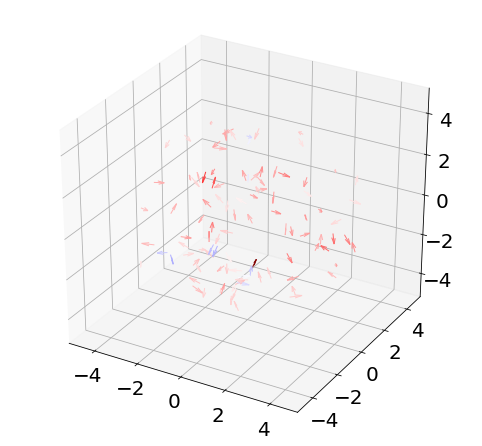

In [193]:
fig = plt.figure(figsize=(6.5,6))
ax = Axes3D(fig)
c = ans*lamb0
cmax = np.max(abs(c-1))
tmp=np.transpose(pos_B)
tmp2=np.transpose(pos_E)

norm = matplotlib.colors.Normalize(vmin=1-cmax, vmax=1+cmax)
cmap = matplotlib.cm.get_cmap("seismic")



c = np.concatenate((c, np.repeat(c, 2)))
ax.quiver(tmp[0], tmp[1], tmp[2], tmp2[0]-tmp[0], tmp2[1]-tmp[1], tmp2[2]-tmp[2], color=cmap(norm(c)), arrow_length_ratio=0.6, lw=1)

ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(-5, 5)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='z', labelsize=20)
#plt.savefig("M100_Di30_random_condensate_k2.png")
plt.savefig("M100_Di1_random_condensate_k2.png")

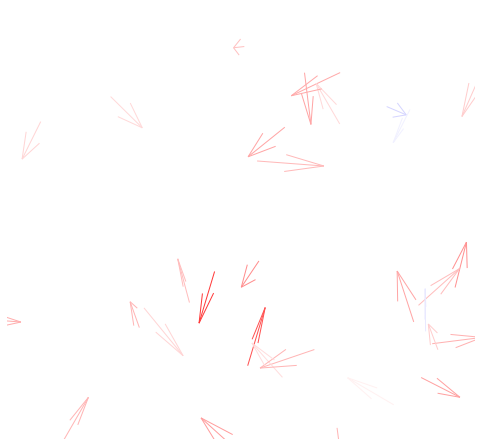

In [194]:
fig = plt.figure(figsize=(6.5,6))
ax = Axes3D(fig)
c = ans*lamb0
cmax = np.max(abs(c-1))
tmp=np.transpose(pos_B)
tmp2=np.transpose(pos_E)

norm = matplotlib.colors.Normalize(vmin=1-cmax, vmax=1+cmax)
cmap = matplotlib.cm.get_cmap("seismic")



c = np.concatenate((c, np.repeat(c, 2)))
ax.quiver(tmp[0], tmp[1], tmp[2], tmp2[0]-tmp[0], tmp2[1]-tmp[1], tmp2[2]-tmp[2], color=cmap(norm(c)), arrow_length_ratio=0.6, lw=1)

ax.set_xlim3d(-2, 0)
ax.set_ylim3d(-2, 0)
ax.set_zlim3d(2, 4)

ax.grid(False)

# Hide axes ticks
plt.axis('off')
#plt.savefig("zoom_M100_Di30_random_condensate_k2.png")
plt.savefig("zoom_M100_Di1_random_condensate_k2.png")

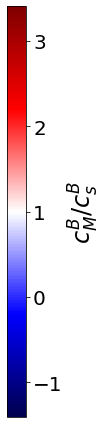

In [198]:
fig, ax = plt.subplots(figsize=(1.6, 6))
cbar=fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax)
cbar.ax.tick_params(labelsize=20) 
cbar.set_label("$c^B_M/c^B_s$", fontsize=24)
plt.tight_layout()
#plt.savefig("cb_M100_Di30_random_condensate_k2.png")
plt.savefig("cb_M100_Di1_random_condensate_k2.png")

In [74]:
def in_green_dipole(pos, pos_E, pos_B, L=5, D_o=30, D_i=1):
    D_p = D_o + D_i
    D_m = D_o - D_i
    
    y2 = lambda t,a1,a2,a3,b1,b2,b3: t**(-D_o/D_p)/((a1-b1*t)**2+(a2-b2*t)**2+(a3-b3*t)**2)**(0.5)
    
    rk_E=L/np.sqrt(np.dot(pos_E,pos_E))
    rk_B=L/np.sqrt(np.dot(pos_B,pos_B))
    vec1 = np.subtract(pos, pos_B)
    vec2 = np.subtract(pos, pos_E)
    vec3 = np.subtract(pos, [rk_B**2*pos_B[0],rk_B**2*pos_B[1],rk_B**2*pos_B[2]])
    vec4 = np.subtract(pos, [rk_E**2*pos_E[0],rk_E**2*pos_E[1],rk_E**2*pos_E[2]])

    lamb = 1/D_i/np.sqrt(np.dot(vec1,vec1))-rk_B*D_m/D_p/D_i/np.sqrt(np.dot(vec3,vec3)) - (1/D_i/np.sqrt(np.dot(vec2,vec2))-rk_E*D_m/D_p/D_i/np.sqrt(np.dot(vec4,vec4))) - \
        (D_m/D_p**2)* \
        (rk_B*integrate.quad(y2, 1, np.inf,args=(pos[0],pos[1],pos[2],rk_B**2*pos_B[0],rk_B**2*pos_B[1],rk_B**2*pos_B[2]))[0] - \
         rk_E*integrate.quad(y2, 1, np.inf,args=(pos[0],pos[1],pos[2],rk_E**2*pos_E[0],rk_E**2*pos_E[1],rk_E**2*pos_E[2]))[0])                        

    lamb = lamb/4/np.pi
    return lamb

In [153]:
def out_green_dipole(pos, pos_E, pos_B, L=5, D_o=30, D_i=1):
    D_p = D_o + D_i
    D_m = D_o - D_i
    
    y2 = lambda t,a1,a2,a3,b1,b2,b3: t**(-D_i/D_p)/((a1-b1*t)**2+(a2-b2*t)**2+(a3-b3*t)**2)**(0.5)

    vec1 = np.subtract(pos, pos_B)
    vec2 = np.subtract(pos, pos_E)

    lamb = 2/D_p/np.sqrt(np.dot(vec1,vec1)) - 2/D_p/np.sqrt(np.dot(vec2,vec2)) - \
        (D_m/D_p**2)* \
        (integrate.quad(y2, 0, 1, args=(pos[0],pos[1],pos[2],pos_B[0],pos_B[1],pos_B[2]))[0] - \
         integrate.quad(y2, 0, 1, args=(pos[0],pos[1],pos[2],pos_E[0],pos_E[1],pos_E[2]))[0])                        

    lamb = lamb/4/np.pi
    return lamb

In [199]:
k_in = 2
L=5
x = np.linspace(-L, L, 100)
y = np.linspace(-L, L, 100)
z = 0
xv, yv, zv = np.meshgrid(x, y, z)
meshT=[]
meshT.append(np.concatenate(xv,axis=None))
meshT.append(np.concatenate(yv,axis=None))
meshT.append(np.concatenate(zv,axis=None))
mesh = np.transpose(meshT)
c=[]
for i in range(len(mesh)):
    con=0
    if np.sqrt(np.dot(mesh[i],mesh[i])) < L:
        for j in range(len(ans)):
            con += ans[j]*in_green_dipole(mesh[i], pos_E[j], pos_B[j], L=5, D_o=30, D_i=1)
    else:
        for j in range(len(ans)):
            con += ans[j]*out_green_dipole(mesh[i], pos_E[j], pos_B[j], L=5, D_o=30, D_i=1)
        
    c.append(1-k_in*con)   

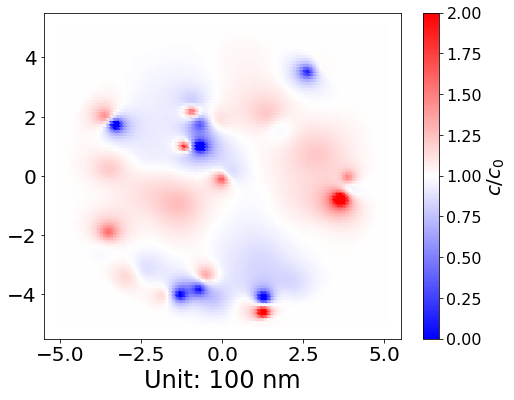

In [201]:
plt.figure(figsize=(8,6))
plt.scatter(meshT[0],meshT[1],c=c,vmin=0,vmax=2,cmap='bwr') 
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlabel("Unit: 100 nm", fontsize=24)
cbar=plt.colorbar()
cbar.set_label(label="$c/c_0$",size=20)
cbar.ax.tick_params(labelsize=16)
#plt.savefig("C_M100_Di30_random_condensate_k2.png")
plt.savefig("C_M100_Di1_random_condensate_k2.png")